# Modeling Guide for Predictive Maintenance

This notebook provides the steps of implementing a predictive maintenance model found in the [Predictive Maintenance Modeling Guide](https://gallery.cortanaintelligence.com/Collection/Predictive-Maintenance-Implementation-Guide-1) collection in the [Cortana Intelligence Gallery](https://gallery.cortanaintelligence.com/).

This is a lightly-modified version of a [notebook](https://gallery.cortanaintelligence.com/Notebook/Predictive-Maintenance-Modelling-Guide-R-Notebook-1) originally created by [Fidan Boylu Uz](https://gallery.cortanaintelligence.com/Home/Author?authorId=C2475BBD3EA55681F67FD54C8799EDDC8C6288409304605B235E39491B4E31CE) (a Microsoft employee) for distribution on the [Cortana Intelligence Gallery](https://gallery.cortanaintelligence.com/). A [corresponding Python version](https://notebooks.azure.com/library/zZfdk23gVbE) is also available on Azure Notebooks.

## Outline

- [Problem Description](#Problem-Description)
- [Data Sources](#Data-Sources)
   - [Telemetry](#Telemetry)
   - [Errors](#Errors)
   - [Maintenance](#Maintenance)
   - [Machines](#Machines)
   - [Failures](#Failures)
- [Feature Engineering](#Feature-Engineering)
  - [Lag Features from Telemetry](#Lag-Features-from-Telemetry)
  - [Lag Features from Errors](#Lag-Features-from-Errors)
  - [Days Since Last Replacement from Maintenance](#Days-Since-Last-Replacement-from-Maintenance)
  - [Machine Features](#Machine-Features)
- [Label Construction](#Label-Construction)
- [Modeling](#Modeling)
  - [Training, Validation and Testing](#Training,-Validation-and-Testing)
  - [Evaluation](#Evaluation)
- [Summary](#Summary)

## Problem Description
A major problem faced by businesses in asset-heavy industries such as manufacturing is the significant costs that are associated with delays in the production process due to mechanical problems. Most of these businesses are interested in predicting these problems in advance so that they can proactively prevent the problems before they occur which will reduce the costly impact caused by downtime. Please refer to the [playbook for predictive maintenance](https://azure.microsoft.com/en-us/documentation/articles/cortana-analytics-playbook-predictive-maintenance/ ) for a detailed explanation of common use cases in predictive maintenance and modeling approaches.

In this notebook, we follow the ideas from the playbook referenced above and aim to provide the steps of implementing a predictive model for a scenario which is based on a synthesis of multiple real-world business problems. This example brings together common data elements observed among many predictive maintenance use cases and the data itself is created by data simulation methods.

The business problem for this example is about predicting problems caused by component failures such that the question "What is the probability that a machine will fail in the near future due to a failure of a certain component" can be answered.  The problem is formatted as a multi-class classification problem and a machine learning algorithm is used to create the predictive model that learns from historical data collected from machines. In the following sections, we go through the steps of implementing such a model which are feature engineering, label construction, training  and evaluation. First, we start by explaining the data sources in the next section.

## Data Sources

Common data sources for predictive maintenance problems are :
- Failure history: The failure history of a machine or component within the machine.
- Maintenance history: The repair history of a machine, e.g. error codes, previous maintenance activities or component replacements.
- Machine conditions and usage: The operating conditions of a machine e.g. data collected from sensors.
- Machine features: The features of a machine, e.g. engine size, make and model, location.
- Operator features: The features of the operator, e.g. gender, past experience

The data for this example comes from 4 different sources which are real-time telemetry data collected from machines, error messages, historical maintenance records that include failures and machine information such as type and age.

In [40]:
system('wget https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_telemetry.csv')
system('wget https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_errors.csv')
system('wget https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_maint.csv')
system('wget https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_failures.csv')
system('wget https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_machines.csv')

telemetry <- read.csv('PdM_telemetry.csv')
errors <- read.csv('PdM_errors.csv')
maint <- read.csv('PdM_maint.csv')
failures <- read.csv('PdM_failures.csv')
machines <- read.csv('PdM_machines.csv')

### Telemetry

The first data source is the telemetry time-series data which consists of voltage, rotation, pressure, and vibration measurements collected from 100 machines in real time averaged over every hour collected during the year 2015. Below, we display the first and last 10 records in the dataset. A summary of the whole dataset is also provided.

In [41]:
# format datetime field which comes in as.character
telemetry$datetime <- as.POSIXct(telemetry$datetime,
                                 format="%Y-%m-%d %H:%M:%S",
                                 tz="UTC")

cat("Total number of telemetry records:", nrow(telemetry))
head(telemetry,10)
tail(telemetry,10)
summary(telemetry)

Total number of telemetry records: 876100

datetime,machineID,volt,rotate,pressure,vibration
2015-01-01 06:00:00,1,176.2179,418.5041,113.07794,45.08769
2015-01-01 07:00:00,1,162.8792,402.7475,95.46053,43.41397
2015-01-01 08:00:00,1,170.9899,527.3498,75.23790,34.17885
2015-01-01 09:00:00,1,162.4628,346.1493,109.24856,41.12214
2015-01-01 10:00:00,1,157.6100,435.3769,111.88665,25.99051
2015-01-01 11:00:00,1,172.5048,430.3234,95.92704,35.65502
2015-01-01 12:00:00,1,156.5560,499.0716,111.75568,42.75392
2015-01-01 13:00:00,1,172.5228,409.6247,101.00108,35.48201
2015-01-01 14:00:00,1,175.3245,398.6488,110.62436,45.48229
2015-01-01 15:00:00,1,169.2184,460.8507,104.84823,39.90174


,datetime,machineID,volt,rotate,pressure,vibration
876091,2015-12-31 21:00:00,100,153.4046,552.0126,99.13295,37.66681
876092,2015-12-31 22:00:00,100,169.3973,546.1446,107.60703,38.69560
876093,2015-12-31 23:00:00,100,152.1820,414.0116,117.42634,43.96671
876094,2016-01-01 00:00:00,100,168.7400,439.4841,103.15823,47.28900
876095,2016-01-01 01:00:00,100,162.7427,481.2539,101.58973,44.38275
876096,2016-01-01 02:00:00,100,179.4382,395.2228,102.29071,50.77194
876097,2016-01-01 03:00:00,100,189.6176,446.2080,98.18061,35.12307
876098,2016-01-01 04:00:00,100,192.4834,447.8165,94.13284,48.31456
876099,2016-01-01 05:00:00,100,165.4753,413.7717,104.08107,44.83526
876100,2016-01-01 06:00:00,100,171.3360,496.0969,79.09554,37.84525


    datetime                     machineID           volt       
 Min.   :2015-01-01 06:00:00   Min.   :  1.00   Min.   : 97.33  
 1st Qu.:2015-04-02 12:00:00   1st Qu.: 25.75   1st Qu.:160.30  
 Median :2015-07-02 18:00:00   Median : 50.50   Median :170.61  
 Mean   :2015-07-02 18:00:00   Mean   : 50.50   Mean   :170.78  
 3rd Qu.:2015-10-02 00:00:00   3rd Qu.: 75.25   3rd Qu.:181.00  
 Max.   :2016-01-01 06:00:00   Max.   :100.00   Max.   :255.12  
     rotate         pressure        vibration    
 Min.   :138.4   Min.   : 51.24   Min.   :14.88  
 1st Qu.:412.3   1st Qu.: 93.50   1st Qu.:36.78  
 Median :447.6   Median :100.43   Median :40.24  
 Mean   :446.6   Mean   :100.86   Mean   :40.39  
 3rd Qu.:482.2   3rd Qu.:107.56   3rd Qu.:43.78  
 Max.   :695.0   Max.   :185.95   Max.   :76.79  

As an example, below is a plot of voltage values for machine ID 1 for the first half of 2015.

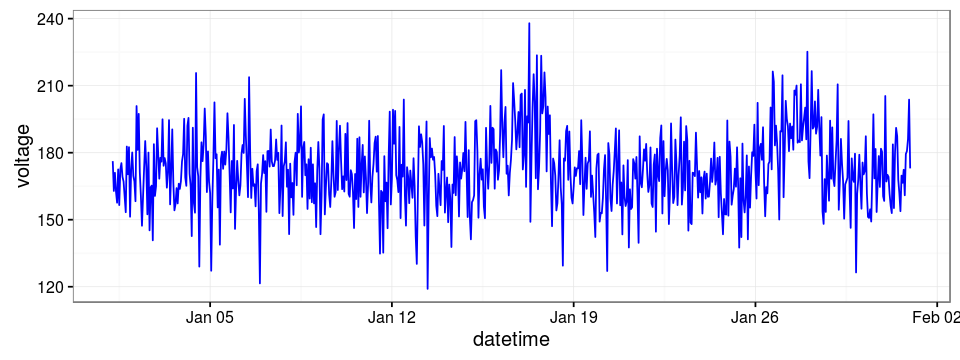

In [42]:
library("ggplot2")
library("dplyr")

theme_set(theme_bw())  # theme for figures
options(repr.plot.width = 8, repr.plot.height = 3)

ggplot(data = telemetry %>% filter(machineID == 1, 
                                 datetime > as.POSIXct("2015-01-01"),
                                 datetime < as.POSIXct("2015-02-01")),
       aes(x = datetime, y = volt)) + geom_line(color = "blue") + labs(y = "voltage")

### Errors

The second major data source is the error logs. These are non-breaking errors thrown while the machine is still operational and do not constitute as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.

In [43]:
# format datetime and errorID fields
errors$datetime <- as.POSIXct(errors$datetime,
                              format="%Y-%m-%d %H:%M:%S", 
                              tz="UTC")
errors$errorID <- as.factor(errors$errorID)

cat("Total number of error records:",nrow(errors))
head(errors,5)

Total number of error records: 3919

datetime,machineID,errorID
2015-01-03 07:00:00,1,error1
2015-01-03 20:00:00,1,error3
2015-01-04 06:00:00,1,error5
2015-01-10 15:00:00,1,error4
2015-01-22 10:00:00,1,error4


### Maintenance

These are the scheduled and unscheduled maintenance records which correspond to both regular inspection of components as well as failures. A record is generated if a component is replaced during the scheduled inspection or replaced due to a breakdown. The records that are created due to breakdowns will be called failures which is explained in the later sections. Maintenance data has both 2014 and 2015 records.

In [44]:
# format datetime and comp fields
maint$datetime <- as.POSIXct(maint$datetime,
                             format="%Y-%m-%d %H:%M:%S", 
                             tz="UTC")
maint$comp <- as.factor(maint$comp)

cat("Total number of maintenance records:", nrow(maint))
head(maint, 10)

Total number of maintenance records: 3286

datetime,machineID,comp
2014-06-01 06:00:00,1,comp2
2014-07-16 06:00:00,1,comp4
2014-07-31 06:00:00,1,comp3
2014-12-13 06:00:00,1,comp1
2015-01-05 06:00:00,1,comp4
2015-01-05 06:00:00,1,comp1
2015-01-20 06:00:00,1,comp3
2015-01-20 06:00:00,1,comp1
2015-02-04 06:00:00,1,comp4
2015-02-04 06:00:00,1,comp3


### Machines

This data set includes some information about the machines: model type and age (years in service).

In [45]:
# format model field
machines$model <- as.factor(machines$model)

cat("Total number of machines:", nrow(machines))
head(machines, 10)
summary(machines)

Total number of machines: 100

machineID,model,age
1,model3,18
2,model4,7
3,model3,8
4,model3,7
5,model3,2
6,model3,7
7,model3,20
8,model3,16
9,model4,7
10,model3,10


   machineID         model         age       
 Min.   :  1.00   model1:16   Min.   : 0.00  
 1st Qu.: 25.75   model2:17   1st Qu.: 6.75  
 Median : 50.50   model3:35   Median :12.00  
 Mean   : 50.50   model4:32   Mean   :11.33  
 3rd Qu.: 75.25               3rd Qu.:16.00  
 Max.   :100.00               Max.   :20.00  

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


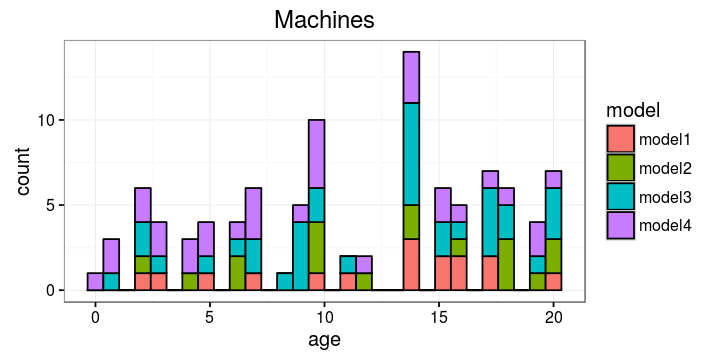

In [46]:
options(repr.plot.width = 6, repr.plot.height = 3)
ggplot(machines, aes(x = age, fill = model)) +
    geom_histogram(color = "black") +
    labs(title = "Machines", x = "age") 

### Failures

These are the records of component replacements due to failures. Each record has a date and time, machine ID, and failed component type.

In [47]:
# format datetime and failure fields
failures$datetime <- as.POSIXct(failures$datetime,
                                format="%Y-%m-%d %H:%M:%S", 
                                tz="UTC")
failures$failure <- as.factor(failures$failure)

cat("Total number of failures:", nrow(failures))
head(failures, 10)

Total number of failures: 761

datetime,machineID,failure
2015-01-05 06:00:00,1,comp4
2015-03-06 06:00:00,1,comp1
2015-04-20 06:00:00,1,comp2
2015-06-19 06:00:00,1,comp4
2015-09-02 06:00:00,1,comp4
2015-10-17 06:00:00,1,comp2
2015-12-16 06:00:00,1,comp4
2015-03-19 06:00:00,2,comp1
2015-03-19 06:00:00,2,comp2
2015-04-18 06:00:00,2,comp2


We see that the most failures happen due to component 2.

[Back to top](#Modelling-Guide-for-Predictive-Maintenance)

## Feature Engineering

The first step in predictive maintenance applications is feature engineering which requires bringing the different data sources together to create features that best describe a machines's health condition at a given point in time. In the next sections, several feature engineering methods are used to create features based on the properties of each data source.



### Lag Features from Telemetry

Telemetry data almost always comes with time-stamps which makes it suitable for calculating lagging features. A common method is to pick a window size for the lag features to be created and compute rolling aggregate measures such as mean, standard deviation, minimum, maximum, etc. to represent the short term history of the telemetry over the lag window. In the following, rolling mean and standard deviation of the telemetry data over the last 3 hour lag window is calculated for every 3 hours.

In [48]:
library("zoo")

# calculate the rolling mean and rolling standard deviation 
# on the last 3 hour lag window (width=3), for every 3 hours (by=3)
# for each machine ID.
telemetrymean <- telemetry %>%
    arrange(machineID, datetime) %>% 
    group_by(machineID) %>%
    mutate(voltmean = rollapply(volt, width = 3, FUN = mean, align = "right", fill = NA, by = 3),
           rotatemean = rollapply(rotate, width = 3, FUN = mean, align = "right", fill = NA, by = 3),
           pressuremean = rollapply(pressure, width = 3, FUN = mean, align = "right", fill = NA, by = 3),
           vibrationmean = rollapply(vibration, width = 3, FUN = mean, align = "right", fill = NA, by = 3)) %>%
    select(datetime, machineID, voltmean, rotatemean, pressuremean, vibrationmean) %>%
    filter(!is.na(voltmean))%>% 
    ungroup()

head(telemetrymean)

datetime,machineID,voltmean,rotatemean,pressuremean,vibrationmean
2015-01-01 08:00:00,1,170.0290,449.5338,94.59212,40.89350
2015-01-01 11:00:00,1,164.1926,403.9499,105.68742,34.25589
2015-01-01 14:00:00,1,168.1344,435.7817,107.79371,41.23941
2015-01-01 17:00:00,1,165.5145,430.4728,101.70329,40.37374
2015-01-01 20:00:00,1,168.8093,437.1111,90.91106,41.73854
2015-01-01 23:00:00,1,168.7794,486.2427,90.44647,41.79666


In [49]:
telemetrysd <- telemetry %>% 
    arrange(machineID, datetime) %>%
    group_by(machineID) %>%
    mutate(voltsd = rollapply(volt, width = 3, FUN = sd, align = "right", fill = NA, by = 3),
           rotatesd = rollapply(rotate, width = 3, FUN = sd, align = "right", fill = NA, by = 3),
           pressuresd = rollapply(pressure, width = 3, FUN = sd, align = "right", fill = NA, by = 3),
           vibrationsd = rollapply(vibration, width = 3, FUN = sd, align = "right", fill = NA, by = 3)) %>%
           select(datetime, machineID, voltsd, rotatesd, pressuresd, vibrationsd) %>%
           filter(!is.na(voltsd)) %>%
           ungroup()

head(telemetrysd)

datetime,machineID,voltsd,rotatesd,pressuresd,vibrationsd
2015-01-01 08:00:00,1,6.721032,67.84960,18.934956,5.874970
2015-01-01 11:00:00,1,7.596570,50.12045,8.555032,7.662229
2015-01-01 14:00:00,1,10.124584,55.08473,5.909721,5.169304
2015-01-01 17:00:00,1,4.673269,42.04728,4.554047,2.106108
2015-01-01 20:00:00,1,14.752132,47.04861,4.244158,2.207884
2015-01-01 23:00:00,1,15.901952,36.12955,4.310741,9.390494


For capturing a longer term effect, 24 hour lag features are also calculated as below.

In [50]:
# calculate the rolling mean and rolling standard deviation 
# on the last 24 hour lag window (width=24), for every 3 hours (by=3)
# for each machine ID.
telemetrymean_24hrs <- telemetry %>%
    arrange(machineID, datetime) %>%
    group_by(machineID) %>%
    mutate(voltmean_24hrs = rollapply(volt, width = 24, FUN = mean, align = "right", fill = NA, by = 3),
           rotatemean_24hrs = rollapply(rotate, width = 24, FUN = mean, align = "right", fill = NA, by = 3),
           pressuremean_24hrs = rollapply(pressure, width = 24, FUN = mean, align = "right", fill = NA, by = 3),
           vibrationmean_24hrs = rollapply(vibration, width = 24, FUN = mean, align = "right", fill = NA, by = 3)) %>%
           select(datetime, machineID, voltmean_24hrs, rotatemean_24hrs, pressuremean_24hrs, vibrationmean_24hrs) %>%
           filter(!is.na(voltmean_24hrs)) %>% 
           ungroup()

head(telemetrymean_24hrs)

datetime,machineID,voltmean_24hrs,rotatemean_24hrs,pressuremean_24hrs,vibrationmean_24hrs
2015-01-02 05:00:00,1,169.7338,445.1799,96.79711,40.38516
2015-01-02 08:00:00,1,170.5257,443.9068,97.66725,39.78667
2015-01-02 11:00:00,1,170.0497,446.4613,96.90616,40.01651
2015-01-02 14:00:00,1,170.3420,447.3553,96.22952,39.92196
2015-01-02 17:00:00,1,170.0606,452.1634,96.35744,39.99047
2015-01-02 20:00:00,1,169.3693,453.3362,98.04201,39.53167


In [51]:
telemetrysd_24hrs <- telemetry %>% 
    arrange(machineID, datetime) %>%
    group_by(machineID) %>%
    mutate(voltsd_24hrs = rollapply(volt, width = 24, FUN = sd, align = "right", fill = NA, by = 3),
           rotatesd_24hrs = rollapply(rotate, width = 24, FUN = sd, align = "right", fill = NA, by = 3),
           pressuresd_24hrs = rollapply(pressure, width = 24, FUN = sd, align = "right", fill = NA, by = 3),
           vibrationsd_24hrs = rollapply(vibration, width = 24, FUN = sd, align = "right", fill = NA, by = 3)) %>%
           select(datetime, machineID, voltsd_24hrs, rotatesd_24hrs, pressuresd_24hrs, vibrationsd_24hrs) %>%
           filter(!is.na(voltsd_24hrs)) %>%
           ungroup()

head(telemetrysd_24hrs)

datetime,machineID,voltsd_24hrs,rotatesd_24hrs,pressuresd_24hrs,vibrationsd_24hrs
2015-01-02 05:00:00,1,11.23312,48.71739,10.079880,5.853209
2015-01-02 08:00:00,1,12.59195,46.93028,9.406795,6.098173
2015-01-02 11:00:00,1,13.27734,42.83678,9.071472,5.481724
2015-01-02 14:00:00,1,13.81716,42.80863,8.256794,5.862312
2015-01-02 17:00:00,1,14.79287,42.52529,8.669605,5.907157
2015-01-02 20:00:00,1,15.67479,41.68962,10.607947,6.205887


Next, the columns of the feature datasets created earlier are merged to create the final feature set from telemetry.

In [52]:
# merge columns of feature sets created earlier
telemetryfeat <- data.frame(telemetrymean, telemetrysd[,-c(1:2)]) 
telemetryfeat_24hrs <- data.frame(telemetrymean_24hrs, telemetrysd_24hrs[,-c(1:2)])
telemetryfeat <- telemetryfeat %>%
                 left_join(telemetryfeat_24hrs, by = c("datetime", "machineID")) %>%
                 filter(!is.na(voltmean_24hrs)) %>% 
                 ungroup()

head(telemetryfeat)
summary(telemetryfeat)

datetime,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,voltmean_24hrs,rotatemean_24hrs,pressuremean_24hrs,vibrationmean_24hrs,voltsd_24hrs,rotatesd_24hrs,pressuresd_24hrs,vibrationsd_24hrs
2015-01-02 05:00:00,1,180.1338,440.6083,94.13797,41.55154,21.32273,48.77051,2.135684,10.037208,169.7338,445.1799,96.79711,40.38516,11.23312,48.71739,10.079880,5.853209
2015-01-02 08:00:00,1,176.3643,439.3497,101.55321,36.10558,18.95221,51.32964,13.789279,6.737739,170.5257,443.9068,97.66725,39.78667,12.59195,46.93028,9.406795,6.098173
2015-01-02 11:00:00,1,160.3846,424.3853,99.59872,36.09464,13.04708,13.70250,9.988609,1.639962,170.0497,446.4613,96.90616,40.01651,13.27734,42.83678,9.071472,5.481724
2015-01-02 14:00:00,1,170.4725,442.9340,102.38059,40.48300,16.64235,56.29045,3.305739,8.854145,170.3420,447.3553,96.22952,39.92196,13.81716,42.80863,8.256794,5.862312
2015-01-02 17:00:00,1,163.2638,468.9376,102.72665,40.92180,17.42469,38.68038,9.105775,3.060781,170.0606,452.1634,96.35744,39.99047,14.79287,42.52529,8.669605,5.907157
2015-01-02 20:00:00,1,163.2785,446.4932,104.38758,38.06812,21.58049,41.38096,20.725597,6.932127,169.3693,453.3362,98.04201,39.53167,15.67479,41.68962,10.607947,6.205887


    datetime                     machineID         voltmean       rotatemean   
 Min.   :2015-01-02 05:00:00   Min.   :  1.00   Min.   :125.5   Min.   :211.8  
 1st Qu.:2015-04-03 05:00:00   1st Qu.: 25.75   1st Qu.:164.4   1st Qu.:427.6  
 Median :2015-07-03 05:00:00   Median : 50.50   Median :170.4   Median :448.4  
 Mean   :2015-07-03 05:00:00   Mean   : 50.50   Mean   :170.8   Mean   :446.6  
 3rd Qu.:2015-10-02 05:00:00   3rd Qu.: 75.25   3rd Qu.:176.6   3rd Qu.:468.4  
 Max.   :2016-01-01 05:00:00   Max.   :100.00   Max.   :241.4   Max.   :586.7  
  pressuremean    vibrationmean       voltsd            rotatesd        
 Min.   : 72.12   Min.   :26.57   Min.   : 0.02551   Min.   :  0.07899  
 1st Qu.: 96.24   1st Qu.:38.15   1st Qu.: 8.02746   1st Qu.: 26.90357  
 Median :100.23   Median :40.15   Median :12.49560   Median : 41.79570  
 Mean   :100.86   Mean   :40.38   Mean   :13.29986   Mean   : 44.45634  
 3rd Qu.:104.40   3rd Qu.:42.23   3rd Qu.:17.68912   3rd Qu.: 59.10372  
 M

### Lag Features from Errors

Like telemetry data, errors come with timestamps. An important difference is that the error IDs are categorical values and should not be averaged over time intervals like the telemetry measurements. Instead, we count the number of errors of each type in a lagging window:

In [53]:
# create a column for each error type
errorcount <- errors %>% select(datetime, machineID, errorID) %>% 
  mutate(error1 = as.integer(errorID == "error1"), 
         error2 = as.integer(errorID == "error2"),
         error3 = as.integer(errorID == "error3"),
         error4 = as.integer(errorID == "error4"),
         error5 = as.integer(errorID == "error5"))

# sum the duplicate errors in an hour
errorcount <- errorcount %>% 
  group_by(machineID,datetime)%>%
  summarise(error1sum = sum(error1), 
            error2sum = sum(error2), 
            error3sum = sum(error3), 
            error4sum = sum(error4), 
            error5sum = sum(error5)) %>%
  ungroup()

head(errorcount)

machineID,datetime,error1sum,error2sum,error3sum,error4sum,error5sum
1,2015-01-03 07:00:00,1,0,0,0,0
1,2015-01-03 20:00:00,0,0,1,0,0
1,2015-01-04 06:00:00,0,0,0,0,1
1,2015-01-10 15:00:00,0,0,0,1,0
1,2015-01-22 10:00:00,0,0,0,1,0
1,2015-01-25 15:00:00,0,0,0,1,0


In [54]:
# align errors with telemetry datetime field
errorfeat <- telemetry %>% 
    select(datetime, machineID) %>%
    left_join(errorcount, by = c("datetime", "machineID"))

# replace missing values
errorfeat[is.na(errorfeat)] <- 0

head(errorfeat)
summary(errorfeat)

datetime,machineID,error1sum,error2sum,error3sum,error4sum,error5sum
2015-01-01 06:00:00,1,0,0,0,0,0
2015-01-01 07:00:00,1,0,0,0,0,0
2015-01-01 08:00:00,1,0,0,0,0,0
2015-01-01 09:00:00,1,0,0,0,0,0
2015-01-01 10:00:00,1,0,0,0,0,0
2015-01-01 11:00:00,1,0,0,0,0,0


    datetime                     machineID        error1sum       
 Min.   :2015-01-01 06:00:00   Min.   :  1.00   Min.   :0.000000  
 1st Qu.:2015-04-02 12:00:00   1st Qu.: 25.75   1st Qu.:0.000000  
 Median :2015-07-02 18:00:00   Median : 50.50   Median :0.000000  
 Mean   :2015-07-02 18:00:00   Mean   : 50.50   Mean   :0.001153  
 3rd Qu.:2015-10-02 00:00:00   3rd Qu.: 75.25   3rd Qu.:0.000000  
 Max.   :2016-01-01 06:00:00   Max.   :100.00   Max.   :1.000000  
   error2sum          error3sum           error4sum           error5sum        
 Min.   :0.000000   Min.   :0.0000000   Min.   :0.0000000   Min.   :0.0000000  
 1st Qu.:0.000000   1st Qu.:0.0000000   1st Qu.:0.0000000   1st Qu.:0.0000000  
 Median :0.000000   Median :0.0000000   Median :0.0000000   Median :0.0000000  
 Mean   :0.001128   Mean   :0.0009565   Mean   :0.0008298   Mean   :0.0004063  
 3rd Qu.:0.000000   3rd Qu.:0.0000000   3rd Qu.:0.0000000   3rd Qu.:0.0000000  
 Max.   :1.000000   Max.   :1.0000000   Max.   :1.0

In [55]:
# count the number of errors of different types in the last 24 hours, for every 3 hours
errorfeat <- errorfeat %>% 
    arrange(machineID, datetime) %>%
    group_by(machineID) %>%
    mutate(error1count = rollapply(error1sum, width = 24, FUN = sum, align = "right", fill = NA, by = 3),
           error2count = rollapply(error2sum, width = 24, FUN = sum, align = "right", fill = NA, by = 3),
           error3count = rollapply(error3sum, width = 24, FUN = sum, align = "right", fill = NA, by = 3),
           error4count = rollapply(error4sum, width = 24, FUN = sum, align = "right", fill = NA, by = 3),
           error5count = rollapply(error5sum, width = 24, FUN = sum, align = "right", fill = NA, by = 3)) %>%
    select(datetime, machineID, error1count, error2count, error3count, error4count, error5count) %>%
    filter(!is.na(error1count)) %>% 
    ungroup()

head(errorfeat)
summary(errorfeat)

datetime,machineID,error1count,error2count,error3count,error4count,error5count
2015-01-02 05:00:00,1,0,0,0,0,0
2015-01-02 08:00:00,1,0,0,0,0,0
2015-01-02 11:00:00,1,0,0,0,0,0
2015-01-02 14:00:00,1,0,0,0,0,0
2015-01-02 17:00:00,1,0,0,0,0,0
2015-01-02 20:00:00,1,0,0,0,0,0


    datetime                     machineID       error1count     
 Min.   :2015-01-02 05:00:00   Min.   :  1.00   Min.   :0.00000  
 1st Qu.:2015-04-03 05:00:00   1st Qu.: 25.75   1st Qu.:0.00000  
 Median :2015-07-03 05:00:00   Median : 50.50   Median :0.00000  
 Mean   :2015-07-03 05:00:00   Mean   : 50.50   Mean   :0.02765  
 3rd Qu.:2015-10-02 05:00:00   3rd Qu.: 75.25   3rd Qu.:0.00000  
 Max.   :2016-01-01 05:00:00   Max.   :100.00   Max.   :2.00000  
  error2count       error3count       error4count      error5count      
 Min.   :0.00000   Min.   :0.00000   Min.   :0.0000   Min.   :0.000000  
 1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.0000   1st Qu.:0.000000  
 Median :0.00000   Median :0.00000   Median :0.0000   Median :0.000000  
 Mean   :0.02707   Mean   :0.02291   Mean   :0.0199   Mean   :0.009753  
 3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.0000   3rd Qu.:0.000000  
 Max.   :2.00000   Max.   :2.00000   Max.   :2.0000   Max.   :2.000000  

### Days Since Last Replacement from Maintenance

A crucial data set in this example is the maintenance records which contain the information of component replacement records. Possible features from this data set can be, for example, the number of replacements of each component in the last 3 months to incorporate the frequency of replacements. However, more relevent information would be to calculate how long it has been since a component is last replaced as that would be expected to correlate better with component failures since the longer a component is used, the more degradation should be expected. 

As a side note, creating lagging features from maintenance data is not as straightforward as for telemetry and errors, so the features from this data are generated in a more custom way. This type of ad-hoc feature engineering is very common in predictive maintenance since domain knowledge plays a big role in understanding the predictors of a problem. In the following, the days since last component replacement are calculated for each component type as features from the maintenance data. 

In [56]:
# create a binary column for each component. 1 if replacement occured, 0 if not.
comprep <- maint %>% 
    select(datetime, machineID, comp) %>% 
    mutate(comp1 = as.integer(comp == "comp1"), 
           comp2 = as.integer(comp == "comp2"),
           comp3 = as.integer(comp == "comp3"),
           comp4 = as.integer(comp == "comp4")) %>%
    select(-comp)

head(comprep)

datetime,machineID,comp1,comp2,comp3,comp4
2014-06-01 06:00:00,1,0,1,0,0
2014-07-16 06:00:00,1,0,0,0,1
2014-07-31 06:00:00,1,0,0,1,0
2014-12-13 06:00:00,1,1,0,0,0
2015-01-05 06:00:00,1,0,0,0,1
2015-01-05 06:00:00,1,1,0,0,0


In [57]:
install.packages("data.table")
library("data.table")

comprep <- as.data.table(comprep)
setkey(comprep, machineID, datetime)

# seperate different component type replacements into different tables
comp1rep <- comprep[comp1 == 1, .(machineID, datetime, lastrepcomp1 = datetime)]# component 1 replacements
comp2rep <- comprep[comp2 == 1, .(machineID, datetime, lastrepcomp2 = datetime)]# component 2 replacements
comp3rep <- comprep[comp3 == 1, .(machineID, datetime, lastrepcomp3 = datetime)]# component 3 replacements
comp4rep <- comprep[comp4 == 1, .(machineID, datetime, lastrepcomp4 = datetime)]# component 4 replacements

# use telemetry feature table datetime and machineID to be matched with replacements
compdate <- as.data.table(telemetryfeat[,c(1:2)]) 
setkey(compdate, machineID, datetime)

# data.table rolling match will attach the latest record from the component replacement tables 
# to the telemetry date time and machineID
comp1feat <- comp1rep[compdate[,.(machineID, datetime)],roll = TRUE] 
comp1feat$sincelastcomp1 <- as.numeric(difftime(comp1feat$datetime, comp1feat$lastrepcomp1, units = "days"))
comp2feat <- comp2rep[compdate[,.(machineID, datetime)], roll = TRUE] 
comp2feat$sincelastcomp2 <- as.numeric(difftime(comp2feat$datetime, comp2feat$lastrepcomp2, units = "days"))
comp3feat <- comp3rep[compdate[,.(machineID, datetime)], roll = TRUE] 
comp3feat$sincelastcomp3 <- as.numeric(difftime(comp3feat$datetime, comp3feat$lastrepcomp3, units="days"))
comp4feat <- comp4rep[compdate[,.(machineID, datetime)], roll = TRUE] 
comp4feat$sincelastcomp4 <- as.numeric(difftime(comp4feat$datetime, comp4feat$lastrepcomp4, units = "days"))

# merge all tables
compfeat <-data.frame(compdate, comp1feat[,.(sincelastcomp1)], comp2feat[,.(sincelastcomp2)],
                      comp3feat[,.(sincelastcomp3)],comp4feat[,.(sincelastcomp4)])

head(compfeat,10)


Installing package into '/home/nbcommon/R'
(as 'lib' is unspecified)


datetime,machineID,sincelastcomp1,sincelastcomp2,sincelastcomp3,sincelastcomp4
2015-01-02 05:00:00,1,19.95833,214.9583,154.9583,169.9583
2015-01-02 08:00:00,1,20.08333,215.0833,155.0833,170.0833
2015-01-02 11:00:00,1,20.20833,215.2083,155.2083,170.2083
2015-01-02 14:00:00,1,20.33333,215.3333,155.3333,170.3333
2015-01-02 17:00:00,1,20.45833,215.4583,155.4583,170.4583
2015-01-02 20:00:00,1,20.58333,215.5833,155.5833,170.5833
2015-01-02 23:00:00,1,20.70833,215.7083,155.7083,170.7083
2015-01-03 02:00:00,1,20.83333,215.8333,155.8333,170.8333
2015-01-03 05:00:00,1,20.95833,215.9583,155.9583,170.9583
2015-01-03 08:00:00,1,21.08333,216.0833,156.0833,171.0833


### Machine Features

The machine features can be used without further modification. These include descriptive information about the type of each machine and its age (number of years in service). If the age information had been recorded as a "first use date" for each machine, a transformation would have been necessary to turn those into a numeric values indicating the years in service.

Lastly, we merge all the feature data sets we created earlier to get the final feature matrix.

In [58]:
# telemetry and error features have the same datetime 
finalfeat <- data.frame(telemetryfeat, errorfeat[,-c(1:2)])

# merge with component features and machine features lastly
finalfeat <- finalfeat %>% 
    left_join(compfeat, by = c("datetime","machineID")) %>% 
    left_join(machines, by = c("machineID"))

head(finalfeat, 10)
cat("The final set of features are:",paste0(names(finalfeat), ","))


datetime,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,...,error2count,error3count,error4count,error5count,sincelastcomp1,sincelastcomp2,sincelastcomp3,sincelastcomp4,model,age
2015-01-02 05:00:00,1,180.1338,440.6083,94.13797,41.55154,21.322735,48.77051,2.135684,10.037208,...,0,0,0,0,19.95833,214.9583,154.9583,169.9583,model3,18
2015-01-02 08:00:00,1,176.3643,439.3497,101.55321,36.10558,18.952210,51.32964,13.789279,6.737739,...,0,0,0,0,20.08333,215.0833,155.0833,170.0833,model3,18
2015-01-02 11:00:00,1,160.3846,424.3853,99.59872,36.09464,13.047080,13.70250,9.988609,1.639962,...,0,0,0,0,20.20833,215.2083,155.2083,170.2083,model3,18
2015-01-02 14:00:00,1,170.4725,442.9340,102.38059,40.48300,16.642354,56.29045,3.305739,8.854145,...,0,0,0,0,20.33333,215.3333,155.3333,170.3333,model3,18
2015-01-02 17:00:00,1,163.2638,468.9376,102.72665,40.92180,17.424688,38.68038,9.105775,3.060781,...,0,0,0,0,20.45833,215.4583,155.4583,170.4583,model3,18
2015-01-02 20:00:00,1,163.2785,446.4932,104.38758,38.06812,21.580492,41.38096,20.725597,6.932127,...,0,0,0,0,20.58333,215.5833,155.5833,170.5833,model3,18
2015-01-02 23:00:00,1,172.1912,434.2147,93.74728,39.71648,16.369836,14.63604,18.817326,3.426997,...,0,0,0,0,20.70833,215.7083,155.7083,170.7083,model3,18
2015-01-03 02:00:00,1,175.2100,504.8454,108.51215,37.76393,5.991921,16.06270,6.382608,3.449468,...,0,0,0,0,20.83333,215.8333,155.8333,170.8333,model3,18
2015-01-03 05:00:00,1,181.6901,472.7832,93.39516,38.62110,11.514450,47.88044,2.177029,7.670520,...,0,0,0,0,20.95833,215.9583,155.9583,170.9583,model3,18
2015-01-03 08:00:00,1,172.3829,505.1413,98.52437,49.96557,7.065150,56.84954,5.230039,2.687565,...,0,0,0,0,21.08333,216.0833,156.0833,171.0833,model3,18


The final set of features are: datetime, machineID, voltmean, rotatemean, pressuremean, vibrationmean, voltsd, rotatesd, pressuresd, vibrationsd, voltmean_24hrs, rotatemean_24hrs, pressuremean_24hrs, vibrationmean_24hrs, voltsd_24hrs, rotatesd_24hrs, pressuresd_24hrs, vibrationsd_24hrs, error1count, error2count, error3count, error4count, error5count, sincelastcomp1, sincelastcomp2, sincelastcomp3, sincelastcomp4, model, age,

[Back to top](#Modelling-Guide-for-Predictive-Maintenance)

## Label Construction

When using multi-class classification for predicting failure due to a problem, labelling is done by taking a time window prior to the failure of an asset and labelling the feature records that fall into that window as "about to fail due to a problem" while labelling all other records as "ÃÂÃÂnormal." This time window should be picked according to the business case: in some situations it may be enough to predict failures hours in advance, while in others days or weeks may be needed to allow e.g. for arrival of replacement parts.

The prediction problem for this example scenerio is to estimate the probability that a machine will fail in the near future due to a failure of a certain component. More specifically, the goal is to compute the probability that a machine will fail in the next 24 hours due to a certain component failure (component 1, 2, 3, or 4). Below, a categorical `failure` feature is created to serve as the label. All records within a 24 hour window before a failure of component 1 have `failure=comp1`, and so on for components 2, 3, and 4; all records not within 24 hours of a component failure have `failure=none`.

In [59]:
# left join final features with failures on machineID then mutate a column for datetime difference
# filter date difference for the prediction horizon which is 24 hours
labeled <- left_join(finalfeat, failures, by = c("machineID")) %>%
    mutate(datediff = difftime(datetime.y, datetime.x, units = "hours")) %>%
    filter(datediff <= 24, datediff >= 0)

# left join labels to final features and fill NA's with "none" indicating no failure
labeledfeatures <- left_join(finalfeat, 
                             labeled %>% select(datetime.x, machineID, failure),
                             by = c("datetime" = "datetime.x", "machineID")) %>%
    arrange(machineID,datetime)

levels(labeledfeatures$failure) <- c(levels(labeledfeatures$failure), "none")
labeledfeatures$failure[is.na(labeledfeatures$failure)]<-"none"
head(labeledfeatures)

datetime,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,...,error3count,error4count,error5count,sincelastcomp1,sincelastcomp2,sincelastcomp3,sincelastcomp4,model,age,failure
2015-01-02 05:00:00,1,180.1338,440.6083,94.13797,41.55154,21.32273,48.77051,2.135684,10.037208,...,0,0,0,19.95833,214.9583,154.9583,169.9583,model3,18,none
2015-01-02 08:00:00,1,176.3643,439.3497,101.55321,36.10558,18.95221,51.32964,13.789279,6.737739,...,0,0,0,20.08333,215.0833,155.0833,170.0833,model3,18,none
2015-01-02 11:00:00,1,160.3846,424.3853,99.59872,36.09464,13.04708,13.70250,9.988609,1.639962,...,0,0,0,20.20833,215.2083,155.2083,170.2083,model3,18,none
2015-01-02 14:00:00,1,170.4725,442.9340,102.38059,40.48300,16.64235,56.29045,3.305739,8.854145,...,0,0,0,20.33333,215.3333,155.3333,170.3333,model3,18,none
2015-01-02 17:00:00,1,163.2638,468.9376,102.72665,40.92180,17.42469,38.68038,9.105775,3.060781,...,0,0,0,20.45833,215.4583,155.4583,170.4583,model3,18,none
2015-01-02 20:00:00,1,163.2785,446.4932,104.38758,38.06812,21.58049,41.38096,20.725597,6.932127,...,0,0,0,20.58333,215.5833,155.5833,170.5833,model3,18,none


Below is an example of records that are labeled as `failure=comp4` in the failure column. Notice that the first 8 records all occur in the 24-hour window before the first recorded failure of component 4. The next 8 records are within the 24 hour window before another failure of component 4.

In [60]:
head(labeledfeatures[labeledfeatures$failure == "comp4",], 16)

,datetime,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,...,error3count,error4count,error5count,sincelastcomp1,sincelastcomp2,sincelastcomp3,sincelastcomp4,model,age,failure
18,2015-01-04 08:00:00,1,166.2818,453.7878,106.18758,51.99008,24.276228,23.621315,11.176731,3.394073,...,1,0,1,22.08333,217.08333,157.08333,172.0833,model3,18,comp4
19,2015-01-04 11:00:00,1,175.4121,445.4506,100.88736,54.25153,34.918687,11.001625,10.580336,2.921501,...,1,0,1,22.20833,217.20833,157.20833,172.2083,model3,18,comp4
20,2015-01-04 14:00:00,1,157.3477,451.8821,101.28938,48.60269,24.617739,28.950883,9.966729,2.356486,...,1,0,1,22.33333,217.33333,157.33333,172.3333,model3,18,comp4
21,2015-01-04 17:00:00,1,176.4506,446.0331,84.52155,47.63884,8.071400,76.511343,2.636879,4.108621,...,1,0,1,22.45833,217.45833,157.45833,172.4583,model3,18,comp4
22,2015-01-04 20:00:00,1,190.3258,422.6926,107.39323,49.55286,8.390777,7.176553,4.262645,7.598552,...,0,0,1,22.58333,217.58333,157.58333,172.5833,model3,18,comp4
23,2015-01-04 23:00:00,1,169.9851,458.9294,91.49436,54.88202,9.451483,12.052752,3.685906,6.621183,...,0,0,1,22.70833,217.70833,157.70833,172.7083,model3,18,comp4
24,2015-01-05 02:00:00,1,149.0826,412.1803,93.50979,54.38608,19.075952,30.715081,3.090266,6.530610,...,0,0,1,22.83333,217.83333,157.83333,172.8333,model3,18,comp4
25,2015-01-05 05:00:00,1,185.7827,439.5313,99.41366,51.55808,14.495664,45.663743,4.289212,7.330397,...,0,0,1,22.95833,217.95833,157.95833,172.9583,model3,18,comp4
1338,2015-06-18 08:00:00,1,169.3246,453.9235,101.31325,53.09227,28.155693,42.557599,7.688674,2.488851,...,0,0,1,89.08333,29.08333,14.08333,134.0833,model3,18,comp4
1339,2015-06-18 11:00:00,1,190.6913,441.5773,97.19251,44.02542,6.296827,47.271008,7.577957,4.648336,...,0,0,1,89.20833,29.20833,14.20833,134.2083,model3,18,comp4


[Back to top](#Modelling-Guide-for-Predictive-Maintenance)

## Modeling

After the feature engineering and labelling steps, either Azure Machine Learning Studio or this notebook can be used to create a predictive model. The recommend Azure Machine Learning Studio experiment can be found in the Cortana Intelligence Gallery: [Predictive Maintenance Modeling Guide Experiment](https://gallery.cortanaintelligence.com/Experiment/Predictive-Maintenance-Modelling-Guide-Experiment-1). Below, we describe the modeling process and provide an example R model. 

### Training, Validation and Testing

When working with time-stamped data as in this example, record partitioning into training, validation, and test sets should be performed carefully to prevent overestimating the performance of the models. In predictive maintenance, the features are usually generated using lagging aggregates: records in the same time window will likely have identical labels and similar feature values. These correlations can give a model an "unfair advantage" when predicting on a test set record that shares its time window with a training set record. We therefore partition records into training, validation, and test sets in large chunks, to minimize the number of time intervals shared between them.

Predictive models have no advance knowledge of future chronological trends: in practice, such trends are likely to exist and to adversely impact the model's performance. To obtain an accurate assessment of a predictive model's performance, we recommend training on older records and validating/testing using newer records.

For both of these reasons, a time-dependent record splitting strategy is an excellent choice for predictive maintenace models. The split is effected by choosing a point in time based on the desired size of the training and test sets: all records before the timepoint are used for training the model, and all remaining records are used for testing. (If desired, the timeline could be further divided to create validation sets for parameter selection.) To prevent any records in the training set from sharing time windows with the records in the test set, we remove any records at the boundary -- in this case, by ignoring 24 hours' worth of data prior to the timepoint.

In [61]:
# split at 2015-08-01 01:00:00, to train on the first 8 months and test on last 4 months
# labelling window is 24 hours so records within 24 hours prior to split point are left out
trainingdata1 <- labeledfeatures[labeledfeatures$datetime < "2015-07-31 01:00:00",] 
testingdata1 <- labeledfeatures[labeledfeatures$datetime > "2015-08-01 01:00:00",]

# split at 2015-09-01 01:00:00, to train on the first 9 months and test on last 3 months
# labelling window is 24 hours so records within 24 hours prior to split point are left out
trainingdata2 <- labeledfeatures[labeledfeatures$datetime < "2015-08-31 01:00:00",] 
testingdata2 <- labeledfeatures[labeledfeatures$datetime > "2015-09-01 01:00:00",]

# split at 2015-10-01 01:00:00, to train on the first 10 months and test on last 2 months
# labelling window is 24 hours so records within 24 hours prior to split point are left out
trainingdata3 <- labeledfeatures[labeledfeatures$datetime < "2015-09-30 01:00:00",] 
testingdata3 <- labeledfeatures[labeledfeatures$datetime > "2015-10-01 01:00:00",]

In [62]:
install.packages("gbm")
library(gbm)

# create the training formula 
trainformula <- as.formula(paste('failure',
                                 paste(names(labeledfeatures)[c(3:29)],collapse=' + '),
                                 sep=' ~ '))
trainformula

Installing package into '/home/nbcommon/R'
(as 'lib' is unspecified)


failure ~ voltmean + rotatemean + pressuremean + vibrationmean + 
    voltsd + rotatesd + pressuresd + vibrationsd + voltmean_24hrs + 
    rotatemean_24hrs + pressuremean_24hrs + vibrationmean_24hrs + 
    voltsd_24hrs + rotatesd_24hrs + pressuresd_24hrs + vibrationsd_24hrs + 
    error1count + error2count + error3count + error4count + error5count + 
    sincelastcomp1 + sincelastcomp2 + sincelastcomp3 + sincelastcomp4 + 
    model + age

In [63]:
# train model on 3 splits
set.seed(1234)
gbm_model1 <- gbm(formula = trainformula, data = trainingdata1, 
                  distribution = "multinomial", n.trees = 50,
                  interaction.depth = 5, shrinkage = 0.1)
gbm_model2 <- gbm(formula = trainformula, data = trainingdata2, 
                  distribution = "multinomial", n.trees = 50,
                  interaction.depth = 5, shrinkage = 0.1)
gbm_model3 <- gbm(formula = trainformula, data = trainingdata3,
                  distribution = "multinomial", n.trees = 50,
                  interaction.depth = 5, shrinkage = 0.1)

,var,rel.inf
error2count,error2count,17.554776435
error5count,error5count,14.922074624
voltmean_24hrs,voltmean_24hrs,14.227104018
vibrationmean_24hrs,vibrationmean_24hrs,12.939775313
error3count,error3count,11.062764325
pressuremean_24hrs,pressuremean_24hrs,9.595631774
rotatemean_24hrs,rotatemean_24hrs,7.292140822
error1count,error1count,6.603279517
error4count,error4count,3.716549280
sincelastcomp1,sincelastcomp1,1.364123515


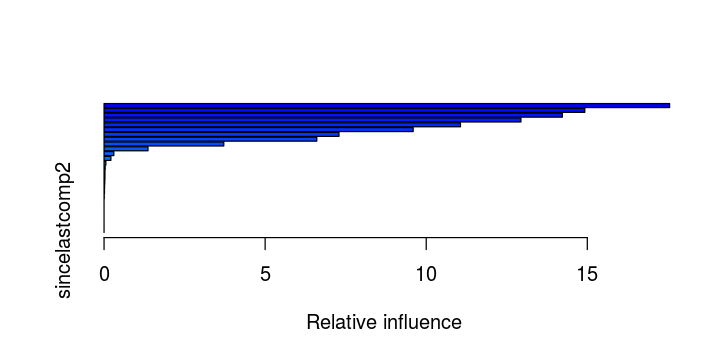

In [64]:
# print relative influence of variables for 1st model as an example
summary(gbm_model1)

## Evaluation

In predictive maintenance, machine failures are usually rare occurrences in the lifetime of the assets compared to normal operation. This causes an imbalance in the label distribution which usually causes poor performance as algorithms tend to classify majority class examples better at the expense of minority class examples as the total misclassification error is much improved when majority class is labeled correctly.  This causes low recall rates although accuracy can be high and becomes a larger problem when the cost of false alarms to the business is very high. To help with this problem, sampling techniques such as oversampling of the minority examples are usually used along with more sophisticated techniques which are not covered in this notebook.

Also, due to the class imbalance problem, it is important to look at evaluation metrics other than accuracy alone and compare those metrics to the baseline metrics which are computed when random chance is used to make predictions rather than a machine learning model.  The comparison will bring out the value and benefits of using a machine learning model better.

In the following, we use an evaluation function that computes many important evaluation metrics along with baseline metrics for classification problems. For a detailed explanation of this function and the metrics please refer to the blog post [Computing Classification Evaluation Metrics in R](http://blog.revolutionanalytics.com/2016/03/com_class_eval_metrics_r.html) .


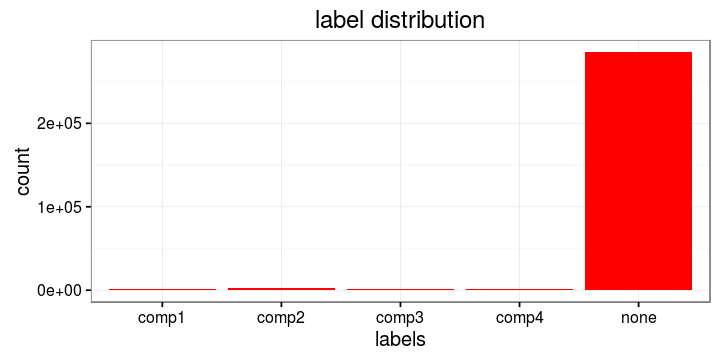

In [65]:
# label distribution after features are labeled - the class imbalance problem
ggplot(labeledfeatures, aes(x=failure)) + 
    geom_bar(fill="red") + 
    labs(title = "label distribution", x = "labels")

In [66]:
# define evaluate function
Evaluate<-function(actual=NULL, predicted=NULL, cm=NULL){
    if(is.null(cm)) {
        actual = actual[!is.na(actual)]
        predicted = predicted[!is.na(predicted)]
        f = factor(union(unique(actual), unique(predicted)))
        actual = factor(actual, levels = levels(f))
        predicted = factor(predicted, levels = levels(f))
        cm = as.matrix(table(Actual=actual, Predicted=predicted))
    }
    
    n = sum(cm) # number of instances
    nc = nrow(cm) # number of classes
    diag = diag(cm) # number of correctly classified instances per class 
    rowsums = apply(cm, 1, sum) # number of instances per class
    colsums = apply(cm, 2, sum) # number of predictions per class
    p = rowsums / n # distribution of instances over the classes
    q = colsums / n # distribution of instances over the predicted classes
    
    #accuracy
    accuracy = sum(diag) / n
    
    #per class
    recall = diag / rowsums
    precision = diag / colsums
    f1 = 2 * precision * recall / (precision + recall)
    
    #macro
    macroPrecision = mean(precision)
    macroRecall = mean(recall)
    macroF1 = mean(f1)
    
    #1-vs-all matrix
    oneVsAll = lapply(1 : nc,
                      function(i){
                          v = c(cm[i,i],
                                rowsums[i] - cm[i,i],
                                colsums[i] - cm[i,i],
                                n-rowsums[i] - colsums[i] + cm[i,i]);
                          return(matrix(v, nrow = 2, byrow = T))})
    
    s = matrix(0, nrow=2, ncol=2)
    for(i in 1:nc){s=s+oneVsAll[[i]]}
    
    #avg accuracy
    avgAccuracy = sum(diag(s))/sum(s)
    
    #micro
    microPrf = (diag(s) / apply(s,1, sum))[1];
    
    #majority class
    mcIndex = which(rowsums==max(rowsums))[1] # majority-class index
    mcAccuracy = as.numeric(p[mcIndex]) 
    mcRecall = 0*p;  mcRecall[mcIndex] = 1
    mcPrecision = 0*p; mcPrecision[mcIndex] = p[mcIndex]
    mcF1 = 0*p; mcF1[mcIndex] = 2 * mcPrecision[mcIndex] / (mcPrecision[mcIndex] + 1)
    
    #random accuracy
    expAccuracy = sum(p*q)
    #kappa
    kappa = (accuracy - expAccuracy) / (1 - expAccuracy)
    
    #random guess
    rgAccuracy = 1 / nc
    rgPrecision = p
    rgRecall = 0*p + 1 / nc
    rgF1 = 2 * p / (nc * p + 1)
    
    #rnd weighted
    rwgAccurcy = sum(p^2)
    rwgPrecision = p
    rwgRecall = p
    rwgF1 = p
    
    classNames = names(diag)
    if(is.null(classNames)) classNames = paste("C",(1:nc),sep="")
    
    return(list(
        ConfusionMatrix = cm,
        Metrics = data.frame(
            Class = classNames,
            Accuracy = accuracy,
            Precision = precision,
            Recall = recall,
            F1 = f1,
            MacroAvgPrecision = macroPrecision,
            MacroAvgRecall = macroRecall,
            MacroAvgF1 = macroF1,
            AvgAccuracy = avgAccuracy,
            MicroAvgPrecision = microPrf,
            MicroAvgRecall = microPrf,
            MicroAvgF1 = microPrf,
            MajorityClassAccuracy = mcAccuracy,
            MajorityClassPrecision = mcPrecision,
            MajorityClassRecall = mcRecall,
            MajorityClassF1 = mcF1,
            Kappa = kappa,
            RandomGuessAccuracy = rgAccuracy,
            RandomGuessPrecision = rgPrecision,
            RandomGuessRecall = rgRecall,
            RandomGuessF1 = rgF1,
            RandomWeightedGuessAccurcy = rwgAccurcy,
            RandomWeightedGuessPrecision = rwgPrecision,
            RandomWeightedGuessRecall= rwgRecall,
            RandomWeightedGuessWeightedF1 = rwgF1)))
}


In [67]:
# evaluation metrics for first split
pred_gbm1 <- as.data.frame(predict(gbm_model1, testingdata1, 
                                   n.trees = 50,type = "response"))

names(pred_gbm1) <- gsub(".50", "", names(pred_gbm1))
pred_gbm1$failure <- as.factor(colnames(pred_gbm1)[max.col(pred_gbm1)])

eval1 <- Evaluate(actual=testingdata1$failure,predicted=pred_gbm1$failure)
eval1$ConfusionMatrix
t(eval1$Metrics)

       Predicted
Actual   comp1  comp2  comp3  comp4   none
  comp1    484     21      2     14      7
  comp2      3    835      9     41      2
  comp3     22      7    383      4      0
  comp4     10     15      4    554      1
  none      14      0      0      5 120315

,comp1,comp2,comp3,comp4,none
Class,comp1,comp2,comp3,comp4,none
Accuracy,0.9985255,0.9985255,0.9985255,0.9985255,0.9985255
Precision,0.9080675,0.9510251,0.9623116,0.8964401,0.9999169
Recall,0.9166667,0.9382022,0.9206731,0.9486301,0.9998421
F1,0.9123468,0.9445701,0.9410319,0.9217970,0.9998795
MacroAvgPrecision,0.9435522,0.9435522,0.9435522,0.9435522,0.9435522
MacroAvgRecall,0.9448028,0.9448028,0.9448028,0.9448028,0.9448028
MacroAvgF1,0.9439251,0.9439251,0.9439251,0.9439251,0.9439251
AvgAccuracy,0.9994102,0.9994102,0.9994102,0.9994102,0.9994102
MicroAvgPrecision,0.9985255,0.9985255,0.9985255,0.9985255,0.9985255


In [68]:
# evaluation metrics for second split
pred_gbm2 <- as.data.frame(predict(gbm_model2, testingdata2,  
                                   n.trees = 50,type = "response"))

names(pred_gbm2) <- gsub(".50", "", names(pred_gbm2))
pred_gbm2$failure <- as.factor(colnames(pred_gbm2)[max.col(pred_gbm2)])

eval2 <- Evaluate(actual=testingdata2$failure,predicted=pred_gbm2$failure)
eval2$ConfusionMatrix
t(eval2$Metrics)


       Predicted
Actual  comp1 comp2 comp3 comp4  none
  comp1   378    15     0     8     7
  comp2     1   693     8    17     3
  comp3     8     8   301     2     1
  comp4    16     9     6   418     1
  none     11     0     0     5 95982

,comp1,comp2,comp3,comp4,none
Class,comp1,comp2,comp3,comp4,none
Accuracy,0.9987129,0.9987129,0.9987129,0.9987129,0.9987129
Precision,0.9130435,0.9558621,0.9555556,0.9288889,0.9998750
Recall,0.9264706,0.9598338,0.9406250,0.9288889,0.9998333
F1,0.9197080,0.9578438,0.9480315,0.9288889,0.9998542
MacroAvgPrecision,0.950645,0.950645,0.950645,0.950645,0.950645
MacroAvgRecall,0.9511303,0.9511303,0.9511303,0.9511303,0.9511303
MacroAvgF1,0.9508653,0.9508653,0.9508653,0.9508653,0.9508653
AvgAccuracy,0.9994852,0.9994852,0.9994852,0.9994852,0.9994852
MicroAvgPrecision,0.9987129,0.9987129,0.9987129,0.9987129,0.9987129


In [69]:
# evaluation metrics for third split
pred_gbm3 <- as.data.frame(predict(gbm_model3, testingdata3,  
                                   n.trees = 50,type = "response"))

names(pred_gbm3)<-gsub(".50", "", names(pred_gbm3))
pred_gbm3$failure <- as.factor(colnames(pred_gbm3)[max.col(pred_gbm3)])

eval3 <- Evaluate(actual=testingdata3$failure,predicted=pred_gbm3$failure)
eval3$ConfusionMatrix
t(eval3$Metrics)

       Predicted
Actual  comp1 comp2 comp3 comp4  none
  comp1   284    12     0     8     2
  comp2     4   555     0     9     2
  comp3     8     0   213     3     0
  comp4     8    15     5   293     1
  none      8     0     0     5 72437

,comp1,comp2,comp3,comp4,none
Class,comp1,comp2,comp3,comp4,none
Accuracy,0.9987817,0.9987817,0.9987817,0.9987817,0.9987817
Precision,0.9102564,0.9536082,0.9770642,0.9213836,0.9999310
Recall,0.9281046,0.9736842,0.9508929,0.9099379,0.9998206
F1,0.9190939,0.9635417,0.9638009,0.9156250,0.9998758
MacroAvgPrecision,0.9524487,0.9524487,0.9524487,0.9524487,0.9524487
MacroAvgRecall,0.952488,0.952488,0.952488,0.952488,0.952488
MacroAvgF1,0.9523874,0.9523874,0.9523874,0.9523874,0.9523874
AvgAccuracy,0.9995127,0.9995127,0.9995127,0.9995127,0.9995127
MicroAvgPrecision,0.9987817,0.9987817,0.9987817,0.9987817,0.9987817


In predictive maintenance, we are often most concerned with how many of the actual failures were predicted by the model, i.e. the model's recall. (Recall becomes more important as the consequences of *false negatives* -- true failures that the model did not predict -- exceed the consequences of *false positives*, viz. false prediction of impending failure.) Below, we compare the recall rates for each failure type for the three models. The recall rates for all components as well as no failure are all above 90% meaning the model was able to capture above 90% of the failures correctly.

In [70]:
# report the recall rates for the models
rownames <- c("comp1","comp2","comp3","comp4","none")
rownames
data.frame(cbind(failure = rownames,
                 gbm_model1_Recall = eval1$Metrics$Recall,
                 gbm_model2_Recall = eval2$Metrics$Recall,
                 gbm_model3_Recall = eval3$Metrics$Recall))

[1] "comp1" "comp2" "comp3" "comp4" "none"

failure,gbm_model1_Recall,gbm_model2_Recall,gbm_model3_Recall
comp1,0.916666666666667,0.926470588235294,0.928104575163399
comp2,0.938202247191011,0.95983379501385,0.973684210526316
comp3,0.920673076923077,0.940625,0.950892857142857
comp4,0.948630136986301,0.928888888888889,0.909937888198758
none,0.999842106137916,0.999833329861039,0.999820565907522


[Back to top](#Modelling-Guide-for-Predictive-Maintenance)

## Summary

In this notebook,  the steps of implementing a predictive maintenance model is provided using an example scenario where the goal is to predict failures due to certain components of a machine. Typical steps of predictive maintenance such as feature engineering, labelling, training and evaluation are explained using the example data sets. Predictive models are built both using R packages and Azure Machine Learning Studio.

[Back to top](#Modelling-Guide-for-Predictive-Maintenance)